### Online training of a limit cycle

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso

from aux import get_flow
from kernels import make_psi_rand_sgm
from disp import set_plot, colors, quiver

In [2]:
# hparams
D = 2
RX = np.linspace(-1.5, 1.5, 15)
DX = np.mean(np.diff(RX))/2

# base system params
TAU = np.array(.01)
B = np.eye(D)
f_base = lambda x: np.zeros(D)
F_base = lambda x, u: (1/TAU)*(-x + f_base(x) + B@u)

DT = .001

# control directions
C = np.array([
    [1., 0],
    [0,  1],
])  #L   U

# kernel
N = 2000
G = 100
J_PSI = G*np.random.randn(N, D)

psi_name = 'rand_sig'
psi, ker = make_psi_rand_sgm(J_PSI)

def ker_vmap(xs, y):
    k_mat = np.nan*np.zeros((len(xs),))
    for cx, x in enumerate(xs):
        k_mat[cx] = ker(x, y)
    return k_mat

def eval_F(x, u, x_stars, alphas):
    
    df = C@alphas.T@ker_vmap(x_stars, x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj(x_stars, alphas, x_init, t, us):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F(xs[ct-1, :], us[ct, :], x_stars, alphas)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

def train(data, x_stars, lam=1e-8):
    """Find alphas using Ridge regression."""
    xs = data[:, :D]
    vs = data[:, D:2*D]
    us = data[:, 2*D:]
    
    # make ys
    f_base_vals = np.array([f_base(x) for x in xs])
    Bus = np.array([B@u for u in us])
    
    ys = TAU*vs + xs - f_base_vals - Bus
    
    # make K
    K = np.array([ker_vmap(xs, x_star) for x_star in x_stars]).T
    
    # find best alphas
    rgr = Ridge(alpha=lam, fit_intercept=False)
    alphas = rgr.fit(K, ys).coef_.T
    return alphas

In [3]:
def plot_quivers(x_stars_all, alphas_all, u=None, arrow_scale=.5):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    flow_base = get_flow(F_base, RX, u=u)
    quiver(axs[0], flow_base, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{base}$')

    F_PRE = lambda x, u: eval_F(x, u, x_stars_all[0], alphas_all[0])
    flow_pre = get_flow(F_PRE, RX, u=u)
    quiver(axs[1], flow_pre, RX)
    
    for x_star, alpha in zip(x_stars_all[0], alphas_all[0]):
        axs[1].scatter(*x_star, c='r')
        axs[1].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{pre}$')

    F_POST = lambda x, u: eval_F(x, u, x_stars_all[-1], alphas_all[-1])
    flow_post = get_flow(F_POST, RX, u=u)
    quiver(axs[2], flow_post, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[2].scatter(*x_star, c='r')
        axs[2].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{post}$')

    quiver(axs[3], flow_post-flow_base, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[3].scatter(*x_star, c='r')
        axs[3].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\Delta \mathbf{f}$')

    return fig, axs

Target flows at specific locations

In [4]:
# data
n_tilde = 96

frq_tilde = 4
# frq_tilde = 1.5
r_tilde = 1.3

t_tilde = np.linspace(0, 1/frq_tilde, n_tilde+1)[:-1]

x_tildes = r_tilde*np.array([np.cos(2*np.pi*frq_tilde*t_tilde), np.sin(2*np.pi*frq_tilde*t_tilde)]).T
v_tildes = 2*np.pi*frq_tilde*r_tilde*np.array([-np.sin(2*np.pi*frq_tilde*t_tilde), np.cos(2*np.pi*frq_tilde*t_tilde)]).T

u_tildes = np.tile(np.array([0., 0]), (len(x_tildes), 1))

data = np.concatenate([x_tildes, v_tildes, u_tildes], axis=1)

Ridge (offline) training

In [5]:
# support states
n_star = 5
theta_stars = np.linspace(-np.pi, np.pi, n_star+1)[:-1]
x_stars = np.array([np.cos(theta_stars), np.sin(theta_stars)]).T

lam = 1e-10
alphas = train(data, x_stars, lam)

irnd = np.random.permutation(len(x_stars))
x_stars = x_stars[irnd, :]
alphas = alphas[irnd, :]

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)

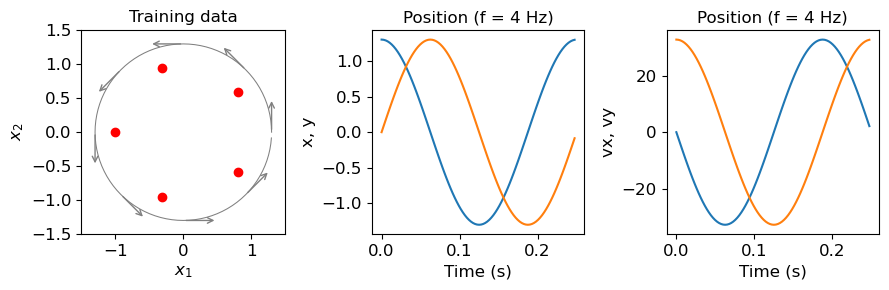

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
# trajectory data
axs[0].plot(*x_tildes.T, c='gray', lw=.75)

# example velocity vectors
scale_vis = 1/np.mean(np.linalg.norm(v_tildes, axis=1))*.5
for i_ in range(0, n_tilde, 12):
    # axs[0].scatter(*x_tildes[i_, :], c='gray')
    xytext = x_tildes[i_, :]
    xy = x_tildes[i_, :] + v_tildes[i_, :]*scale_vis
    axs[0].annotate("", xytext=xytext, xy=xy,
            arrowprops=dict(arrowstyle="->", color='gray'))

# support states
for x_star in x_stars:
    axs[0].scatter(*x_star, c='red')

axs[0].set_aspect('equal')
set_plot(axs[0], x_lim=(-1.5, 1.5), y_lim=(-1.5, 1.5), x_label=r'$x_1$', y_label=r'$x_2$', title='Training data')
axs[1].plot(t_tilde, x_tildes)
set_plot(axs[1], x_label='Time (s)', y_label='x, y', title=f'Position (f = {frq_tilde} Hz)')
axs[2].plot(t_tilde, v_tildes)
set_plot(axs[2], x_label='Time (s)', y_label='vx, vy', title=f'Position (f = {frq_tilde} Hz)')

fig.savefig('ms/3_lim_cyc_targ_and_x_stars.svg')

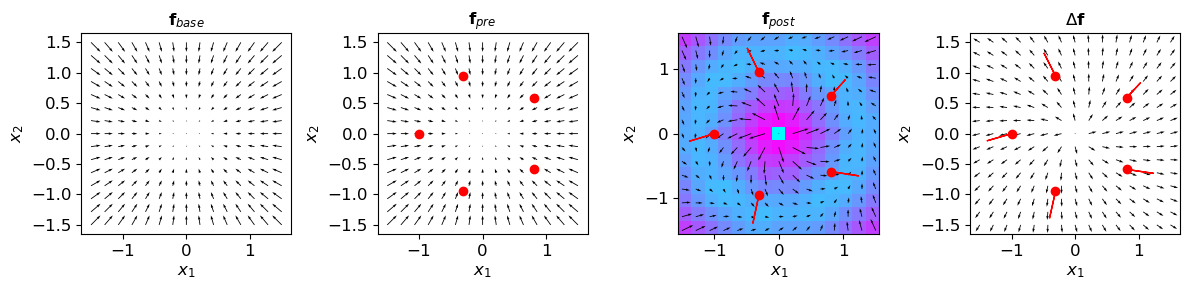

In [7]:
# plot flow fields
x_stars_all = [x_stars, x_stars]
alphas_all = [0*alphas, alphas]
fig, axs = plot_quivers(x_stars_all, alphas_all, arrow_scale=.3, u=np.array([0., 0]))

flow_post = get_flow(F_POST, RX, u=np.array([0., 0]))
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[2].xaxis.tick_bottom()

fig.savefig('ms/s2_lim_cyc_ridge_sln.svg')

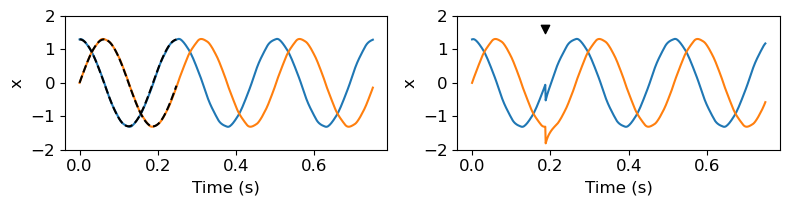

In [9]:
# simulated trajecs using ridge-trained system
t = np.arange(0, 3/frq_tilde, DT)

us_0 = np.zeros((len(t), D))
us_ptb = np.zeros((len(t), D))

t_ptb = .25*3/frq_tilde
it_ptb = int(round(t_ptb/DT))
us_ptb[it_ptb, :] = 5*np.array([-1, -1.])

us_all = [us_0, us_ptb]

x_inits = [np.array([r_tilde, 0.]), np.array([r_tilde, 0.])]
xs_all = [smlt_trj(x_stars, alphas, x_init, t, us) for x_init, us in zip(x_inits, us_all)]

fig, axs = plt.subplots(1, 2, figsize=(8, 2.15), tight_layout=True)
for ax, xs in zip(axs, xs_all):
    ax.plot(t, xs)
    set_plot(ax, y_lim=(-2, 2), x_label='Time (s)', y_label='x')
    
axs[0].plot(t_tilde, x_tildes[:, 0], c='k', ls='--')
axs[0].plot(t_tilde, x_tildes[:, 1], c='k', ls='--')

axs[1].scatter(t_ptb, 1.6, marker='v', c='k')

fig.savefig('ms/s2_lim_cyc_ridge_trajecs.svg')

Online training

In [9]:
LAM = 1000

T_START = 0.01
IT_START = int(T_START//DT)

T_HOLD = 0.05
IT_HOLD = int(T_HOLD//DT)

T_PAUSE = .01
IT_PAUSE = int(T_PAUSE//DT)

In [10]:
def eval_F_primal(x, u, W):
    
    df = C@W.T@psi(x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj_primal(W, x_init, t, us):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F_primal(xs[ct-1, :], us[ct, :], W)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

In [11]:
def plot_quivers_primal(eval_F_primal, u=None):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    
    F_primal = lambda x, u: eval_F_primal(x, u, W)
    flow = get_flow(F_primal, RX, u=u)
    
    quiver(axs[0], flow, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$')

    return fig, axs

In [12]:
# create learning input and signals
t_learn = np.arange(0, (len(x_stars)+1)*(T_HOLD+T_PAUSE), DT)
us_learn = np.zeros((len(t_learn), D))
ls = np.zeros((len(t_learn), D))

it_temp = IT_START

for cx_star, (x_star, alpha) in enumerate(zip(x_stars, alphas)):
    us_learn[it_temp:it_temp+IT_HOLD, :] = LAM*x_star
    ls[it_temp+IT_HOLD-1, :] = 1/DT*alpha

    it_temp += (IT_HOLD + IT_PAUSE)

In [13]:
# train network online
W = np.zeros((N, D))

xs = np.nan*np.zeros((len(t_learn), D))
xs[0, :] = np.zeros(D)

for ct, t_ in enumerate(t_learn[1:], 1):
    dx = DT*eval_F_primal(xs[ct-1, :], us_learn[ct, :], W)
    xs[ct, :] = xs[ct-1, :] + dx

    # implement plasticity rule
    if np.linalg.norm(ls[ct]) > 0:
        for d in range(D):
            W[:, d] += (DT*ls[ct, d]*psi(xs[ct, :]))

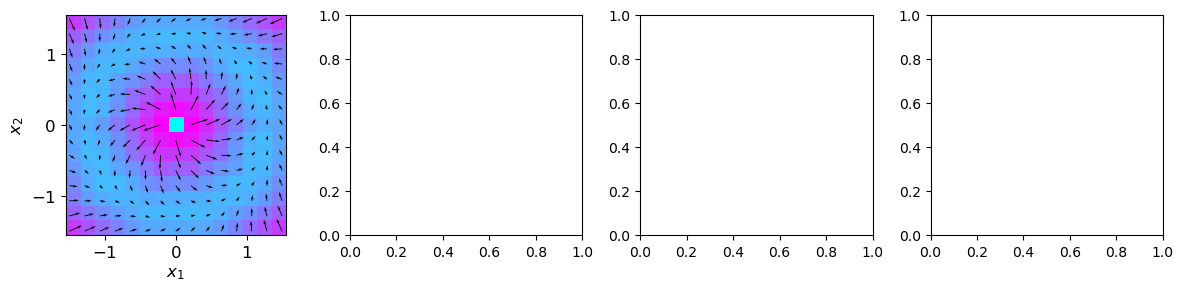

In [14]:
# plot flow fields
fig, axs = plot_quivers_primal(eval_F_primal, u=np.array([0., 0]))

F_POST = lambda x, u: eval_F_primal(x, u, W)
flow_post = get_flow(F_POST, RX, u=np.array([0., 0]))
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[0].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[0].xaxis.tick_bottom()

fig.savefig('ms/3_lim_cyc_online_sln.svg')

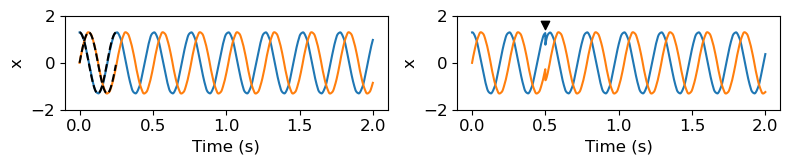

In [15]:
# simulated trajecs using online-trained system
t = np.arange(0, 2., DT)

us_0 = np.zeros((len(t), D))
us_ptb = np.zeros((len(t), D))

t_ptb = .25*t.max()
it_ptb = int(round(t_ptb/DT))
us_ptb[it_ptb, :] = 5*np.array([-1, -1.])

us_all = [us_0, us_ptb]

x_inits = [np.array([r_tilde, 0.]), np.array([r_tilde, 0.])]
xs_all = [smlt_trj_primal(W, x_init, t, us) for x_init, us in zip(x_inits, us_all)]

fig, axs = plt.subplots(1, 2, figsize=(8, 1.75), tight_layout=True)
for ax, xs in zip(axs, xs_all):
    ax.plot(t, xs)
    set_plot(ax, y_lim=(-2, 2), x_label='Time (s)', y_label='x')
    
axs[0].plot(t_tilde, x_tildes[:, 0], c='k', ls='--')
axs[0].plot(t_tilde, x_tildes[:, 1], c='k', ls='--')

axs[1].scatter(t_ptb, 1.6, marker='v', c='k')

fig.savefig(f'ms/3_lim_cyc_online_frq_{frq_tilde}.svg')